In [0]:
import glob
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from segnet import SegNet
from unet import UNet

In [0]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

In [154]:
if use_cuda:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
if use_cuda:
    path_to_images = '/content/drive/My Drive/train/raw_images'
    path_to_annotations = '/content/drive/My Drive/train/annotations_white'
else:
    path_to_images = 'train/raw_images'
    path_to_annotations = 'train/annotations_white'

transform_pipe = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    torchvision.transforms.RandomCrop(size=(400, 400)),
    
    torchvision.transforms.RandomHorizontalFlip(0.5),
    
    torchvision.transforms.RandomVerticalFlip(0.5),
    
    torchvision.transforms.ToTensor()
])

# Unet resize transform
transform_resize = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    torchvision.transforms.Resize((212, 212)),
    
    torchvision.transforms.ToTensor()
])

data_norm = torchvision.transforms.Normalize(mean=[0.78092086, 0.5018261, 0.7803567],
                                 std=[0.16727196, 0.24176046, 0.13103652])
anno_norm =  torchvision.transforms.Normalize(mean=[0.00202586], std=[0.00176733])


class CustomDataset(Dataset):
    
    def __init__(self, img_list, anno_list, num_of_classes=2, transform=None):
        
        self.img_list = img_list
        self.anno_list = anno_list
        self.num_of_classes = num_of_classes
        self.transform = transform
        
    def __getitem__(self, img_id):
        
        image = Image.open(img_list[img_id])
        img = np.array(image)
        anno = np.array(Image.open(self.anno_list[img_id]).convert("L"))

        seed = np.random.randint(2147483647)
        random.seed(seed)
        if self.transform:
            img = self.transform(img)
            img = data_norm(img)
            random.seed(seed)
            anno = self.transform(anno)
            anno = transform_resize(anno)     # unet resize
            # anno = anno_norm(anno)


        anno[anno>0] = 1
        anno_reshaped = np.zeros((self.num_of_classes, anno.shape[1], anno.shape[2]))
        for i in range(self.num_of_classes):
            anno_reshaped[i, :, :][anno[0] == i] = 1

        anno_reshaped = anno_norm(torch.from_numpy(anno_reshaped))
        sample = {"image": img, "annotation": anno_reshaped}
        return sample
    
    
    def __len__(self):
        return len(self.img_list)

img_list = glob.glob(path_to_images + os.sep + "*.bmp")
img_list = sorted(img_list)
anno_list = glob.glob(path_to_annotations + os.sep + "*.bmp")
anno_list = sorted(anno_list)
dataset_train = CustomDataset(img_list, anno_list, 2, transform=transform_pipe)


In [0]:
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size = 3,
    shuffle=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 3, 400, 400)


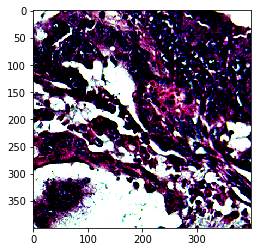

torch.Size([3, 2, 212, 212])


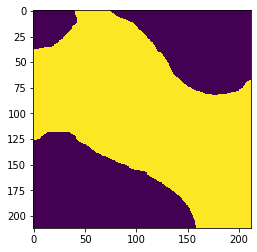

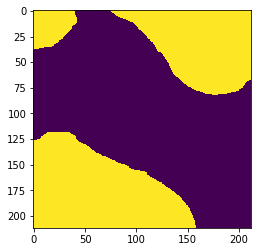

In [157]:
data = [batch_data for batch_data in dataloader_train]
batch_data = data[0]
fig_img = plt.figure()
print(batch_data['image'].numpy().shape)
plt.imshow(batch_data['image'][0].permute(1, 2, 0).numpy())
plt.show()
print(batch_data['annotation'].shape)
batch_data['annotation'] = batch_data['annotation']
plt.imshow(batch_data['annotation'][0][0])
fig_img.suptitle('image')
plt.show()
plt.imshow(batch_data['annotation'][0][1])
plt.show()

In [158]:
# net = SegNet(2, n_init_features=3) # input channels, output channels
net = UNet(2, n_init_features=3)
if use_cuda:
    net.cuda()

/content/unet.py:37: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)


In [0]:
LEARNING_RATE = 0.001
# criterion = nn.CrossEntropyLoss() for multiple class
criterion = nn.BCEWithLogitsLoss() 

# optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
# optimizer = optim.SGD(net.parameters(), LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), 1e-3, (0.9, 0.999),  eps=1e-08, weight_decay=1e-4)

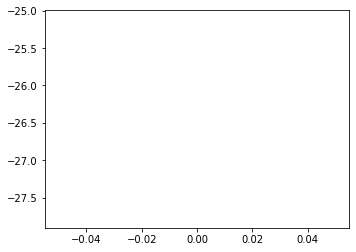

train loss:  -26.4497115568669


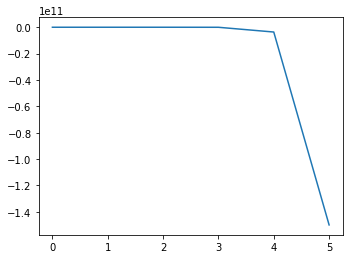

train loss:  -150007624147.6446


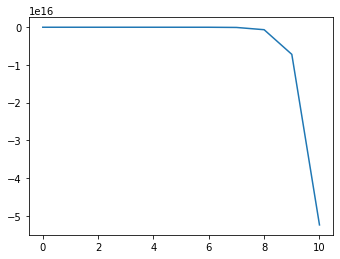

train loss:  -5.243721719300503e+16


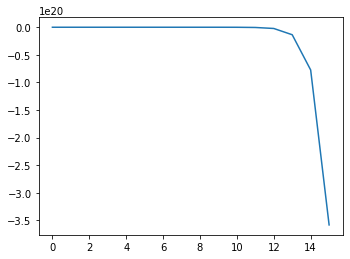

train loss:  -3.5847695711765804e+20


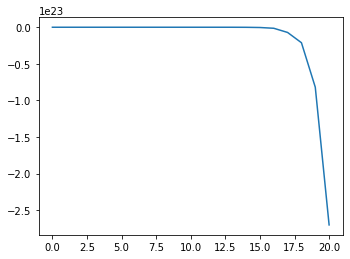

train loss:  -2.702804911511396e+23


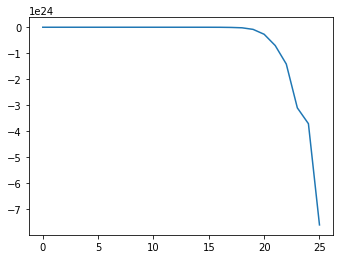

train loss:  -7.60172177621863e+24
Train, it: 0 loss: -8176628414523853129121792.00


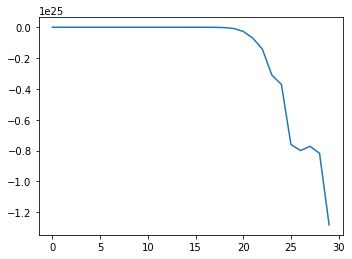

train loss:  -1.2815346411726474e+25


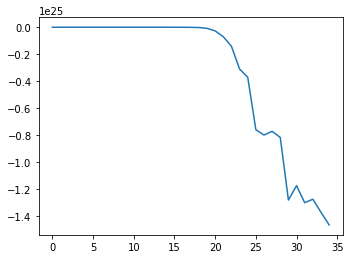

train loss:  -1.4661533720312495e+25


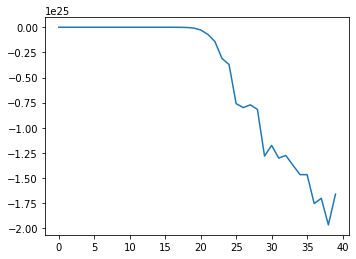

train loss:  -1.6602143514492798e+25


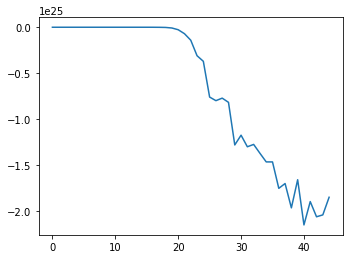

train loss:  -1.8510776772187166e+25


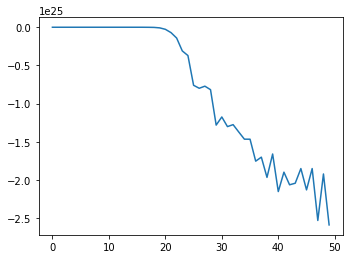

train loss:  -2.5890774172774273e+25


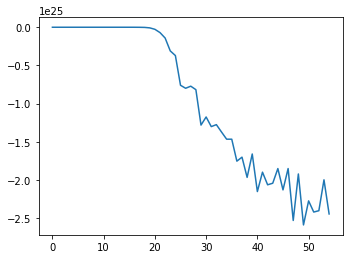

train loss:  -2.4453738623279806e+25
Train, it: 1 loss: -23958175457291855284142080.00


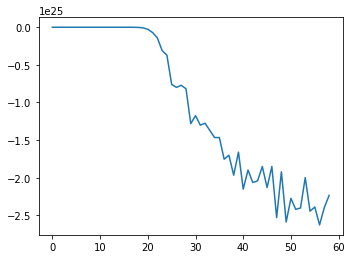

train loss:  -2.235326348514713e+25


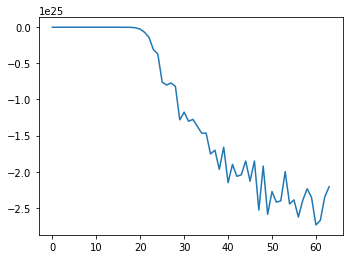

train loss:  -2.2067073006339252e+25


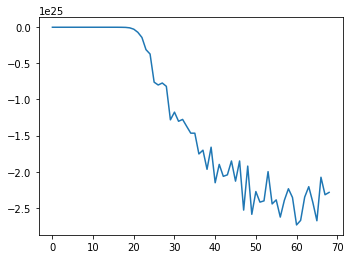

train loss:  -2.285698720246027e+25


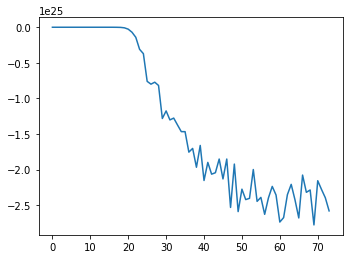

train loss:  -2.5791429086791805e+25


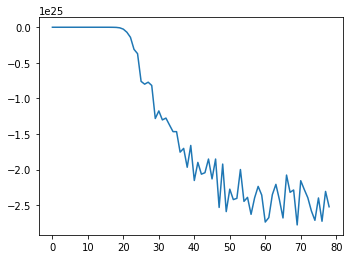

train loss:  -2.5212058018015906e+25


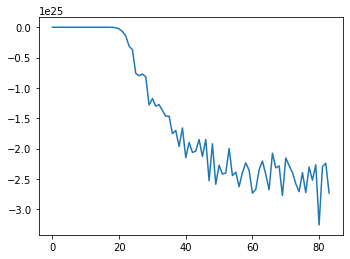

train loss:  -2.7336894029724314e+25
Train, it: 2 loss: -19142065735923218151112704.00


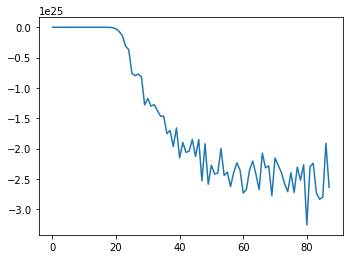

train loss:  -2.6380561991129994e+25


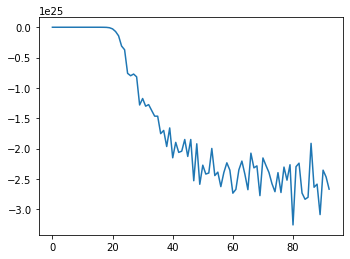

train loss:  -2.669244082846113e+25


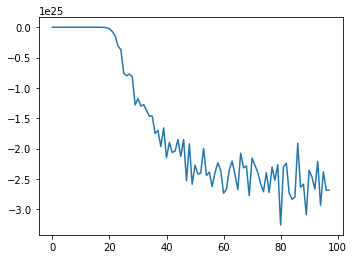

train loss:  -2.687057666909217e+25


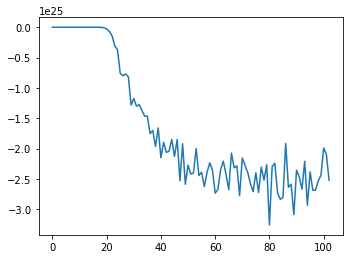

train loss:  -2.5236893065988943e+25


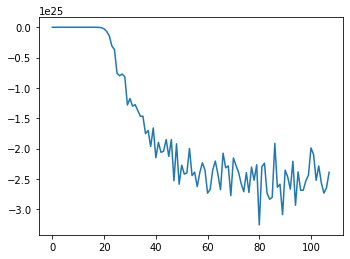

train loss:  -2.3915879951321706e+25


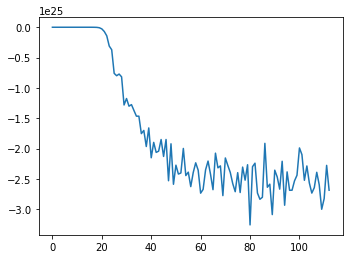

train loss:  -2.687204451646712e+25
Train, it: 3 loss: -26112254718922760940158976.00


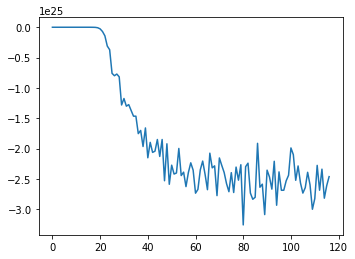

train loss:  -2.4631757601443547e+25


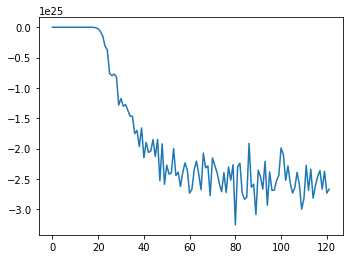

train loss:  -2.6704247231067677e+25


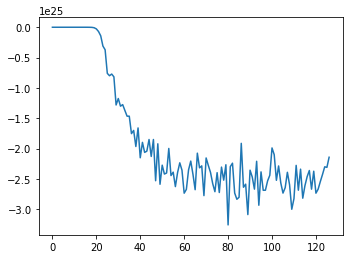

train loss:  -2.143531450943666e+25


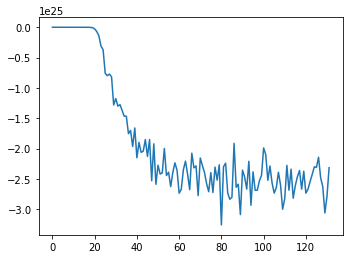

train loss:  -2.315910363724781e+25


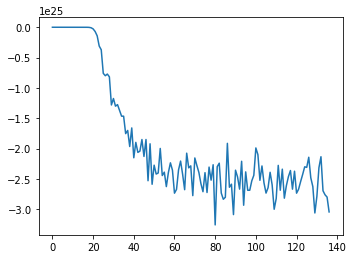

train loss:  -3.0448794431549747e+25


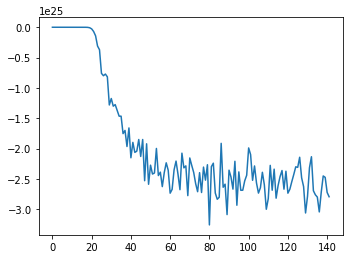

train loss:  -2.794590217547237e+25
Train, it: 4 loss: -26607330815114471310098432.00


In [160]:
max_iter = 5
log_every = 100
eval_every = 100

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

batch_iter = 0
# Train network
net.train()
for i in range(max_iter):
    for j, batch_train in enumerate(dataloader_train):
        # Train
        inputs = get_variable(Variable(batch_train['image']))
        anno = get_variable(Variable(batch_train['annotation']))
        output = net(inputs)
        batch_loss = criterion(output, anno)

        train_iter.append(batch_iter)
        batch_iter += 1
        b_loss = float(get_numpy(batch_loss))
        train_loss.append(b_loss)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        if j % 5 == 0:
            fig = plt.figure(figsize=(12,4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_loss, label='train_loss')
            plt.show()
            # clear_output(wait=True)
            print("train loss: ", train_loss[-1])

    print("Train, it: {} loss: {:.2f}".format(i, train_loss[-1]))


input shape: torch.Size([3, 3, 400, 400])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


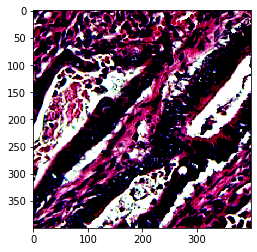

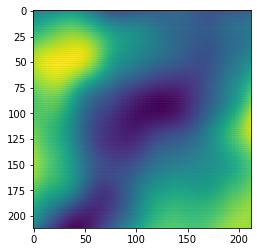

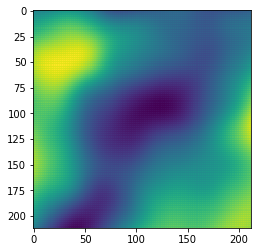

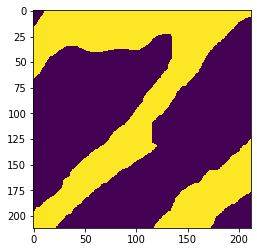

In [161]:
batch_data = data[6]
fig_img = plt.figure()
inputs = get_variable(Variable(batch_data['image']))
anno = batch_data['annotation']
output = net(inputs)
print('input shape:', inputs.shape)
plt.imshow(get_numpy(inputs[0].permute(1, 2, 0)))
plt.show()
fig_img.suptitle('image')
plt.imshow(get_numpy(output[0][0]))
plt.show()
plt.imshow(get_numpy(output[0][1]))
plt.show()
plt.imshow(anno[0][0])
plt.show()

In [162]:
anno = get_variable(Variable(anno))
loss = criterion(output, anno)
print(get_numpy(loss))

-2.4990617580778266e+25
